In [1]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(weights="FCN_ResNet101_Weights.DEFAULT").eval()

In [3]:
import torch
import torchvision.transforms as T

In [4]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os

In [5]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [6]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

In [7]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [34]:
def get_seg(net, img, show=True, dev='cpu'):
    
    if not type(img)==PIL.Image.Image:
        img = Image.fromarray(img)
    
    size_x = np.array(img).shape[0]
    size_y = np.array(img).shape[1]
    
    if show: plt.figure(figsize=(15,5))
    
    if show: plt.subplot(1,3,1);plt.imshow(img); plt.axis('off');
    
    
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize((size_x,size_y)), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    #plt.imshow(rgb); plt.axis('off'); plt.show()
    
    #seg_resized = Image.fromarray(rgb).resize((512,512),resample=PIL.Image.NEAREST)
    
    #bg = (np.array(seg_resized)==0).sum(axis=-1)==3
    #img_copy = np.array(img).copy()
    #img_copy[:,:,0][bg] = 0
    #img_copy[:,:,1][bg] = 0
    #img_copy[:,:,2][bg] = 0
    #Image.fromarray(img_copy)
    
    if show: plt.subplot(1,3,2);plt.imshow(rgb); plt.axis('off');
    
    if show: plt.subplot(1,3,3);plt.imshow(seg_resized); plt.axis('off');
    
    
    if show: plt.show()
    
    return rgb

In [33]:
np.array(Image.fromarray(video_data[0,:,:,:])).shape[0]

360

In [9]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)
        
def safe_mkdir_subdirs(fn):
    fn_split = fn.split('/')
    n = len(fn.split('/'))
    paths = ['/'.join(fn_split[0:i]) for i in range(0,n) if len('/'.join(fn_split[0:i]))>1]
    for path in paths:
        safe_mkdir(path)

In [11]:
### GET PATHS

In [12]:
indir = './Data/haa500_v1_1/video'
folders = os.listdir(indir) ; folders.sort()

videos = []
for folder in folders:
    cont = [file for file in os.listdir(os.path.join(indir,folder)) if file.endswith('.mp4')]
    videos.append(cont)
    
print(len(folders))
print(np.array([len(folder) for folder in videos]))

500

array([20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20

In [16]:
## RUN Segmentation loop

In [17]:
from datetime import datetime
now = datetime.now

In [35]:
f = 0
v = 0

In [36]:
fn = os.path.join(indir,folders[f],videos[f][v])

ofn = fn.replace('haa500_v1_1','haa500_v1_1_seg')
safe_mkdir('/'.join(ofn.split('/')[0:-1]))

print(f'segmenting folder {f} video {v} | {now()}')
video_data = load_video(fn)
video_seg = np.array([get_seg(fcn,video_data[i,:,:,:],show=False) for i in range(video_data.shape[0])])
#save_video(video_seg,ofn)

segmenting folder 0 video 0 | 2023-01-22 05:52:03.475678


In [37]:
video_data.shape

(44, 360, 360, 3)

In [38]:
video_seg.shape

(44, 360, 360, 3)

(-0.5, 359.5, 359.5, -0.5)

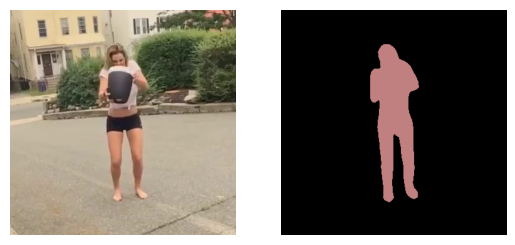

In [39]:
plt.subplot(1,2,1)
plt.imshow(video_data[0,:,:,:]);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(video_seg[0,:,:,:]);plt.axis('off')

In [61]:
def cut_out_bg(video_data,video_seg):
    video_data_cut_bg = video_data.copy()
    for i in range(video_data.shape[0]):
        frame = video_data[i,:,:,:]
        frame_seg = video_seg[i,:,:,:]
        frame_mask = (frame_seg[:,:,0]==192) * (frame_seg[:,:,1]==128) * (frame_seg[:,:,2]==128)
        frame_copy = frame.copy()
        frame_copy[~frame_mask]=0
        video_data_cut_bg[i,:,:,:] = frame_copy
    return video_data_cut_bg

In [ ]:
print(f'started time {now()}')
for f in range(500):
    for v in range(20):
        fn = os.path.join(indir,folders[f],videos[f][v])
        
        ofn = fn.replace('haa500_v1_1','haa500_v1_1_seg')
        safe_mkdir_subdirs('/'.join(ofn.split('/')))
        
        ofn_no_bg = fn.replace('haa500_v1_1','haa500_v1_1_no_bg')
        safe_mkdir_subdirs('/'.join(ofn_no_bg.split('/')))
        
        print(f'segmenting folder {f} video {v} | {now()}')
        video_data = load_video(fn)
        video_seg = np.array([get_seg(fcn,video_data[i,:,:,:],show=False) for i in range(video_data.shape[0])])
        video_data_cut_bg = cut_out_bg(video_data,video_seg)
        save_video(video_seg,ofn)
        save_video(video_data_cut_bg,ofn_no_bg)

started time 2023-01-22 06:30:50.499069
segmenting folder 0 video 0 | 2023-01-22 06:30:50.499769
segmenting folder 0 video 1 | 2023-01-22 06:30:59.117792
segmenting folder 0 video 2 | 2023-01-22 06:32:07.292049
segmenting folder 0 video 3 | 2023-01-22 06:32:56.404473
segmenting folder 0 video 4 | 2023-01-22 06:33:04.798240
segmenting folder 0 video 5 | 2023-01-22 06:34:16.644544
segmenting folder 0 video 6 | 2023-01-22 06:36:20.805659
segmenting folder 0 video 7 | 2023-01-22 06:37:24.805399
segmenting folder 0 video 8 | 2023-01-22 06:38:15.336504
segmenting folder 0 video 9 | 2023-01-22 06:39:22.525746
segmenting folder 0 video 10 | 2023-01-22 06:40:15.120537
segmenting folder 0 video 11 | 2023-01-22 06:41:54.933980
segmenting folder 0 video 12 | 2023-01-22 06:42:54.161040
segmenting folder 0 video 13 | 2023-01-22 06:43:55.875536
segmenting folder 0 video 14 | 2023-01-22 06:44:14.256295
segmenting folder 0 video 15 | 2023-01-22 06:45:34.259867
segmenting folder 0 video 16 | 2023-01-22 